# Tidy table from SNPs

This data set uses the contig-based analysis from SPAdes + snippy

## Overview of input data set

Untidy table created with

```bash
$ for i in 14028S Azi-* C*; do  grep CP0 ${i}/snps.csv | cut -d "," -f2-5 -  | gawk -v var=$i '{print var",", $0}'; done > all_snps.persample 

$ cat all_snps.persample

Cip-biofilm-M-B-S3snps, 34842,snp,G,T
Cef-biofilm-E-D-S1snps, 34864,snp,T,C
...
Cip-biofilm-L-A-S2snps, 4856471,del,CT,C
Cip-biofilm-L-A-S3snps, 4866470,snp,G,T
Cip-biofilm-L-B-S3snps, 4866471,snp,A,G
```

In [1]:
## load necessary libraries
library(tidyverse);
library(glmnet);
library(gplots);
#options(jupyter.plot_mimetypes = "image/svg+xml") ## creates SVG but not downloadable...

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loaded glmnet 3.0-1


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [2]:
## replace long names, to facilitate reading

# with read.table() we can use fact that names and snps.csv are seaprated by space, besides the comma
a <- read.table("data/all_snps.persample");
a[1:4,]
x1names <- gsub("CATTATAAAACTTCGATAATAAAATATTATTTTTT","CAT...TTT", a[,2]);
x1names <- gsub("TTTCAGACCCTGGCGCTTGGCCCAGGAGAGGGCGCC","TT..CC", x1names);
x1names <- gsub("AAAAAAATCCAAATTGATTTACATCAATTAAC","AA...AC", x1names);
x1names <- gsub("ATGAAATAATAAAA,TGAAATAATAAAG","A..A,T..G", x1names);
x1names <- gsub("GCCGTCTTT,ACAGGCTCC","G..T,A..T", x1names);
x1names <- gsub("CATGAGAGTGTGAGT","CAT...AGT", x1names);
x1names <- gsub("ACCGCCG","A.G", x1names);
x1names <- gsub("complex","cplx", x1names);
#x1names <- gsub("","", x1names);
a[,2] <- x1names

V1,V2
<fct>,<fct>
"Cip-biofilm-M-B-S3snps,","34842,snp,G,T"
"Cef-biofilm-E-D-S1snps,","34864,snp,T,C"
"Cip-biofilm-M-B-S3snps,","34942,snp,G,T"
"Cip-biofilm-M-B-S2snps,","63608,snp,C,G"


## create tidy table
* `tib[]` will have zero/one if SNP is absent/present (SNP is actually any variant described by `snippy`)
* `genloc_order` will reorder columns by genomic location 

In [3]:
unt <- cbind (a, 1) ## add column with value repreesnting "presence" of SNP
names(unt) <- c("sample", "snp", "presence")
tib <- unt %>% spread (key=snp, value=presence, fill=0) ## `fill` replaces NA with zero
rownames(tib) <- gsub("snps,","",tib[,1])
tib <- tib[,2:length(tib)] # remove first column, with names

#genloc_order <- order(as.integer(gsub(",\\w+","", colnames(tib))))
genloc_order <- order(as.integer(gsub(",.*","", colnames(tib))))
tib <- tib[,genloc_order]
tib0 <- tib
tib[14:16,]

,"34842,snp,G,T","34864,snp,T,C","34942,snp,G,T","63608,snp,C,G","63707,snp,G,C","75572,snp,T,C","95893,snp,C,T","95950,snp,A,G","95965,snp,T,C","95976,snp,A,G",⋯,"4610002,snp,C,A","4673804,snp,G,T","4678363,snp,A,T","4728318,snp,T,C","4766627,snp,T,C","4781891,snp,G,A","4791206,snp,A,G","4856471,del,CT,C","4866470,snp,G,T","4866471,snp,A,G"
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Azi-plank-M-S3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Cef-biofilm-E-C-S1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
Cef-biofilm-E-D-S1,0,1,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Create vectors with phenotypical information
* `phen[]` will have biofilm/plank information
* `abx[]` contains Azi, Cef, Cip. Both `abx` and `phen` have at first Control information as well.
* All controls are removed, and thus a SNP thas was present only in Control may be absent in all samples. 

In [4]:
# control samples
phen <- gsub("-\\w+","", gsub("^\\w*?-","", rownames(tib)))
phen[grep ("14028S", phen)] <- "control"
t_control <- tib[grep ("control", phen),]

abx <- gsub("-\\w+","", rownames(tib))
abx[grep ("control", phen)] <- "control"
table(abx)
abx0 <- abx

## remove controls (keep only Azi, Cef, Cip)
tib <- tib[abx!="control",]
phen <- phen[abx!="control"]
abx <- abx[abx!="control"]
table(abx)

not_in_ref <- as.logical(!tib0[grep ("14028S", rownames(tib0)),]) # SNPs absent from 14028S

abx
    Azi     Cef     Cip control 
     13      19      24       8 

abx
Azi Cef Cip 
 13  19  24 

In [5]:
print (paste("original length:", length(tib[1,])));
tib <- tib[,not_in_ref]
print (paste("after removing SNPs present in 14028S:", length(tib[1,])));
## remove columns with only one value (all zero or all one)
## - only after removing everything related to controls, since we change the column order
tib <- tib[vapply(tib, function(x) length(unique(x)) > 1, logical(1L))]
#tib <- tib[, colSums(tib != 0) > 0] ## remove all zeroes
print (paste("after removing columns with no variation:", length(tib[1,])));

[1] "original length: 475"
[1] "after removing SNPs present in 14028S: 454"
[1] "after removing columns with no variation: 392"


* At this stage only SNPs 'unique' to the ABX conditions are retained (that is, those present in our reference 14028S were excluded, as well as columns with all SNPs present or all absent)

In [6]:
# split data into ABX condition
t_azi <- tib[grep ("Azi", abx),]
p_azi <- phen[grep ("Azi", abx)]
t_cef <- tib[grep ("Cef", abx),]
p_cef <- phen[grep ("Cef", abx)]
t_cip <- tib[grep ("Cip", abx),]
p_cip <- phen[grep ("Cip", abx)]
p_cip

[1] "biofilm" "biofilm" "biofilm" "biofilm" "biofilm" "biofilm" "biofilm"
 [8] "biofilm" "biofilm" "biofilm" "biofilm" "biofilm" "biofilm" "biofilm"
[15] "biofilm" "biofilm" "biofilm" "plank"   "plank"   "plank"   "plank"  
[22] "plank"   "plank"   "plank"

In [7]:
## unique values only, per condition (ABX-specific SNPs, cannot be compared between ABX) 
## This is an extra analysis, plotted at the end of notebook. 
u_azi <- t_azi[vapply(t_azi, function(x) length(unique(x)) > 1, logical(1L))]; length(u_azi[1,])
u_cef <- t_cef[vapply(t_cef, function(x) length(unique(x)) > 1, logical(1L))]; length(u_cef[1,])
u_cip <- t_cip[vapply(t_cip, function(x) length(unique(x)) > 1, logical(1L))]; length(u_cip[1,])

[1] 83

[1] 86

[1] 274

## Penalised Logistic Regression 
* outcome variable is biofilm/plank
* Elastic nets are a mixture of lasso (thisalpha=1) and ridge regression (thisalpha=0); We use here only visually, to determine which SNPs we could show that are associated to biofilm/planktonic status.

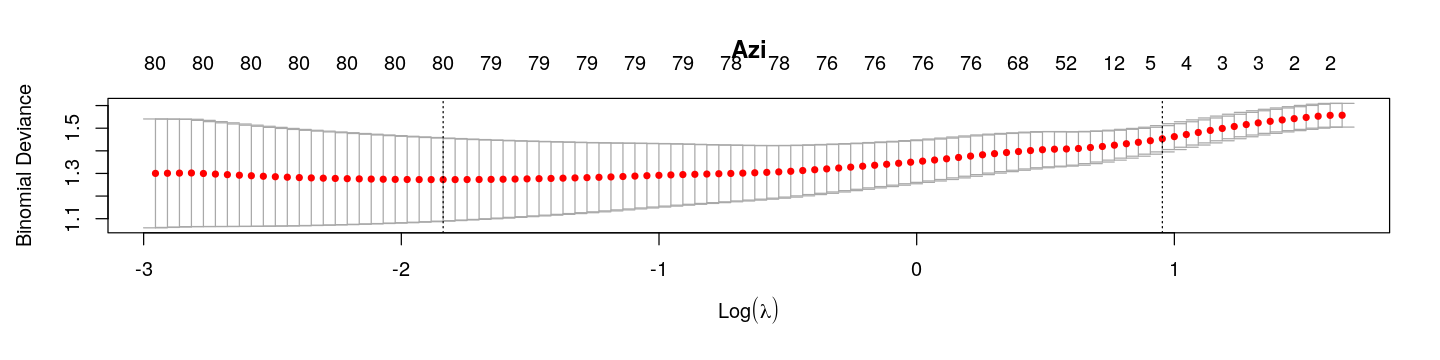

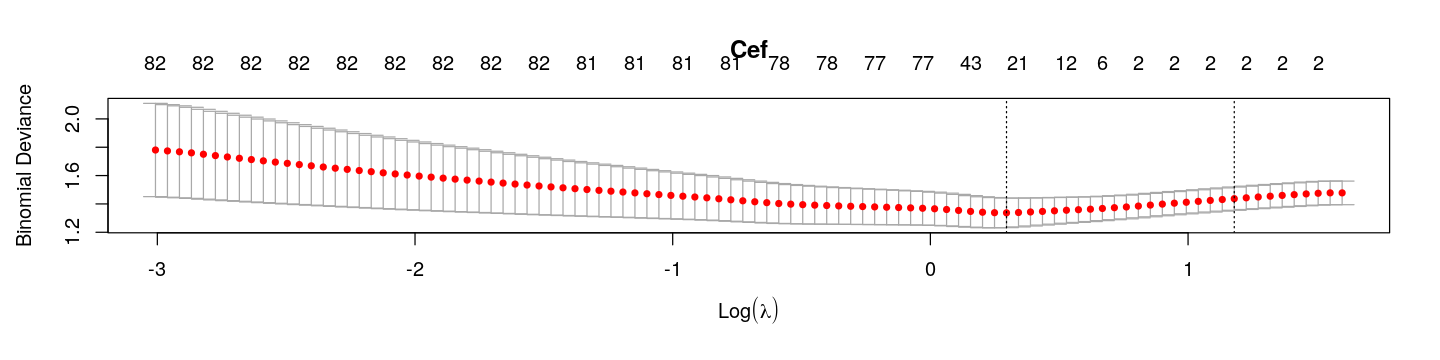

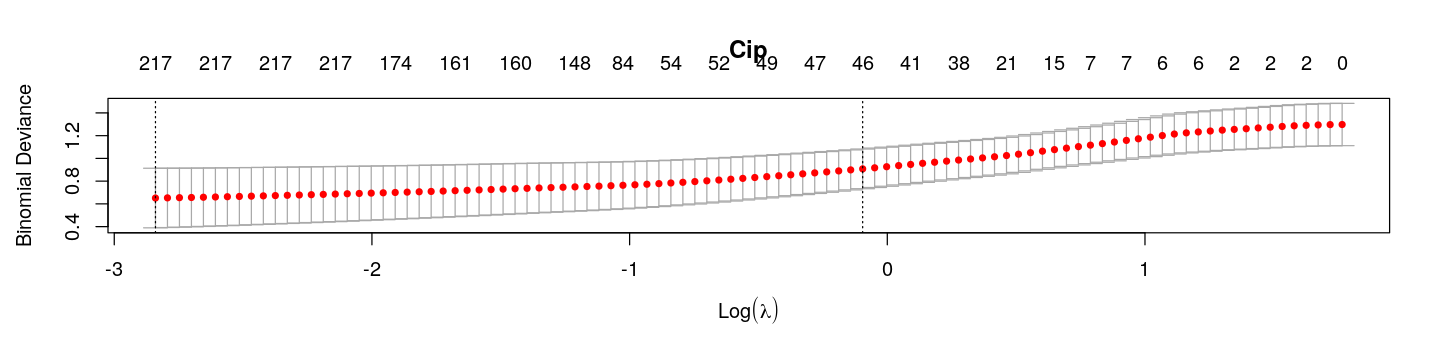

In [11]:
options(warn=-1) ## supress warnings (about not having enough samples)
thisalpha <- 0.07
lasso_a <- cv.glmnet(as.matrix(t_azi), as.factor(p_azi), family = "binomial", alpha = thisalpha, nfolds=200)
lasso_e <- cv.glmnet(as.matrix(t_cef), as.factor(p_cef), family = "binomial", alpha = thisalpha, nfolds=200)
lasso_i <- cv.glmnet(as.matrix(t_cip), as.factor(p_cip), family = "binomial", alpha = thisalpha, nfolds=200)

options(repr.plot.width=12, repr.plot.height=3);
par(oma=c(0.2,0.4,0,0)); 
plot(lasso_a, main="Azi")
plot(lasso_e, main="Cef")
plot(lasso_i, main="Cip")

**Figure caption: the plot above shows the cross-validation error from distinct choices of $\lambda$. The algorithm automatically chose the best $\lambda$ (leftmost dotted vertical line). At the top of each panel we see the number of SNPs chosen (the others have a coefficient of zero, in the regression).**

### more details about the penalised regression
* In our model, the phenotype is biofilm/plank, and the controls were removed. Each ABX is analysed independently.
* We chose an arbitrary $\alpha$ for the elastic net -- the higher the $\alpha$ the closer it resembles a lasso (which tries to remove as many SNPs as possible). Low values are closer to a ridge regression.

**lambda.min:** optimal value of lambda (through minimal cross-validation error)

**lambda.1se:** simplest model (i.e. fewer nonzero coeff) which lies within one standard error of *lambda.min*


## Table with non-zero SNPs, from three ABX conditions
* After applying regression to each ABX condition data set independently, we merge the resulting regression coefficients. 
* main use is visualisation (since we have 400 SNPs in total, above)
* This uses the 3 ABX at same time (so we can create a single table), but for heatmap visualisation we may create independent ones
* I also plot the SNPs corresponding to indels 

In [ ]:
allcoefs_1se <- cbind(as.matrix(coef(lasso_a, lasso_a$lambda.1se)),
                      as.matrix(coef(lasso_e, lasso_e$lambda.1se)), 
                      as.matrix(coef(lasso_i, lasso_i$lambda.1se)) )
allcoefs_min <- cbind(as.matrix(coef(lasso_a, lasso_a$lambda.min)), 
                      as.matrix(coef(lasso_e, lasso_e$lambda.min)), 
                      as.matrix(coef(lasso_i, lasso_i$lambda.min)) )
colnames (allcoefs_1se) <- c("Azi", "Cef", "Cip")
colnames (allcoefs_min) <- c("Azi", "Cef", "Cip")

## decide if non-zero are optimal (min) or smaller set (1se)
nonzero <- apply(allcoefs_min,1,function(x) any(x^2 > 0))

## remove columns with only one value (all zero or all one)
tib_nz <- tib[,nonzero[2:length(nonzero)]]  ## nonzero will have intercept
length(tib_nz[1,])
t_azi_nz <- tib_nz[grep ("Azi", abx),]
t_cef_nz <- tib_nz[grep ("Cef", abx),]
t_cip_nz <- tib_nz[grep ("Cip", abx),]
                 
tmpn <- colnames(tib_nz[1,]) ## chosen snps
tmpn[grep("ins", tmpn)]
tmpn[grep("del", tmpn)]

## Visualisation of differences: average SNP composition per group
* If no samples have SNP, then it's white, if all have it then it's black. beige means polymorphism
* only non-zero-coefficient variants are shown, using regression above (all ABX conditions together) 

In [ ]:
x1 <-           colMeans(t_azi_nz[grep ("biofilm", p_azi),]); 
x1 <- rbind(x1, colMeans(t_azi_nz[grep ("plank", p_azi),]));
x1 <- rbind(x1, colMeans(t_cef_nz[grep ("biofilm", p_cef),])); 
x1 <- rbind(x1, colMeans(t_cef_nz[grep ("plank", p_cef),]));
x1 <- rbind(x1, colMeans(t_cip_nz[grep ("biofilm", p_cip),])); 
x1 <- rbind(x1, colMeans(t_cip_nz[grep ("plank", p_cip),]));
rownames (x1) <- c("Azi biofilm", "Azi plank","Cef biofilm", "Cef plank", "Cip biofilm", "Cip plank")
x1 <- as.matrix(x1)

## https://stackoverflow.com/questions/24621070/heatmap-2-with-color-key-on-top 
plot_seg_heat <- function (xmat) {
    par(pin=c(0,0), oma=c(12,0,0,5)); 
    options(repr.plot.width=28, repr.plot.height=10);
    print(length(xmat[1,]));
    heatmap.2 (xmat,
           col= colorRampPalette(c("snow", "azure3", "goldenrod1", "indianred4", "black"))(32), 
           rowsep=1:12, colsep=1:450, 
           scale="none", 
           sepwidth=c(0.04, 0.1),
           cexCol=1.5, cexRow=2.2, 
           dendrogram="none",
           lmat = rbind( c(0,4), c(0, 3), c(2,1) ), lhei=c(1, 0.1, 5), lwid=c(1,12), 
           Rowv = FALSE, Colv=FALSE,
           density.info="none",
           #margins=c(15,10),
           key=TRUE, keysize=0.8, key.ylab=NA, key.xlab=NA, symkey=FALSE, symbreaks=FALSE, key.title = NA, 
            key.par=list(cex.axis=2.5, tcl=0.1, mar=c(3,0,0.1,0.1)), 
           tracecol=NA);
}

#for (i in seq(1,length(x1[1,]), by=50)) {
#   last <- i + 49; if (last > length(x1[1,])) {last <- length(x1[1,]);}
leng <- 4
idx <- as.integer(seq(1,length(x1[1,])+1, length.out=leng)); # last plus one since below we substract one from last
for (i in 1:(leng-1)) {
    plot_seg_heat (x1[,idx[i]:(idx[i+1]-1)]);
}

### The figures below show the SNPs associated with biofilm/plank, for each data set

* The blue dots are the SNPs found by the LASSO regression above.
* The red lines are the difference in mean values between biofilm and plank. In detail: if we take the "average" SNP value for each group (biofilm or plank), then we end up with two vector, of the "consensus" SNP. The red lines show the difference between the two consensus, for each SNP.
* The red lines should not be over-interpreted (since they just show a pooled tendency), but lines longer than $0.5$ (in any direction) are those found even by `lambda.1se` (i.e. the most parsimounious/stringent model). A perfect association would lead to `+1` or `-1`. 
* The order of the SNPs may **not** be equivalent to their genome locations: they are treated as a categorical variable and are ordered lexycographically, probably. (below this image we have a description of them)

In [ ]:
plot_heat1 <- function (tibble, height, factor) {
    options(repr.plot.width=28, repr.plot.height=height); par(oma=c(13,0,0,12));
    print(length(tibble[1,]));
    heatmap.2 (as.matrix(tibble),
               col= c("gainsboro", "brown3"), ## color already fixed 2010.01.13
               rowsep=1:30, colsep=1:500,
               scale="none",
               cexCol=1.5,  ## works for at least 110 columns
               cexRow=factor,
               dendrogram="none",
               Colv=FALSE, Rowv=FALSE,
               lhei=c(1,20),
               lwid=c(1,20), lwd=3,
               tracecol=NA,
               key=FALSE,
               sepwidth=c(0.02, 0.1));
               #title=heat_title);
}
leng <- 4
idx <- as.integer(seq(1,length(t_azi_nz[1,])+1, length.out=leng)); # last plus one since below we substract one from last
for (i in 1:(leng-1)) {
    plot_heat1(as.matrix(t_azi_nz)[,idx[i]:(idx[i+1]-1)], height=12, factor=2.1);
}
for (i in 1:(leng-1)) {
    plot_heat1(as.matrix(t_cef_nz)[,idx[i]:(idx[i+1]-1)], height=14, factor=2.2);
}
for (i in 1:(leng-1)) {
    plot_heat1(as.matrix(t_cip_nz)[,idx[i]:(idx[i+1]-1)], height=17, factor=2.3);
}

## Each data set, with their unique SNPs
* The columns are in the original order (genomic position) but **are not the same** same accross ABX conditions
* We removed all non-segregating sites for each data set independently for each ABX condition, therefore the number of columns is distinct. By "non-segregating" I mean all present or all absent. I.e. only positions with informative SNPs are shown.
* Red means SNP present, and gray means absent.

In [ ]:
plot_heat1 <- function (tibble, height, factor) {
    options(repr.plot.width=28, repr.plot.height=height); par(oma=c(12,0,0,12));
    print(length(tibble[1,]));
    heatmap.2 (as.matrix(tibble),
               col= c("cornsilk", "tomato4"), ## color already fixed 2010.01.13
               rowsep=1:30, colsep=1:500,
               scale="none",
               cexCol=1.4,
               cexRow=factor,
               dendrogram="none",
               Colv=FALSE, Rowv=FALSE,
               lhei=c(1,20),
               lwid=c(1,20), lwd=3,
               tracecol=NA,
               key=FALSE,
               sepwidth=c(0.02, 0.1));
               #title=heat_title);
}
leng <- 2
idx <- as.integer(seq(1,length(u_azi[1,])+1, length.out=leng)); # last +1 since below we use last -1
for (i in 1:(leng-1)) {
    plot_heat1(as.matrix(u_azi)[,idx[i]:(idx[i+1]-1)], height=12, factor=2.1);
}
idx <- as.integer(seq(1,length(u_cef[1,])+1, length.out=leng)); 
for (i in 1:(leng-1)) {
    plot_heat1(as.matrix(u_cef)[,idx[i]:(idx[i+1]-1)], height=14, factor=2.2);
}
leng <- 4
idx <- as.integer(seq(1,length(u_cip[1,])+1, length.out=leng)); 
for (i in 1:(leng-1)) {
    plot_heat1(as.matrix(u_cip)[,idx[i]:(idx[i+1]-1)], height=17, factor=2.3);
}